# Kernel SAX for ETT hourly dataset

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from tqts.quantizer.kernel_sax import KernelSAX
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 6)

DATA_DIR = "../data/"
IMG_DIR = "../images/"

### Preprocessing functions

In [2]:
def load_dataset(file_path: str) -> pd.DataFrame:
    return pd.read_csv(file_path, index_col=0, parse_dates=True)

In [3]:
def test_stationarity(timeseries: pd.Series) -> bool:
    """
    Perform Augmented Dickey-Fuller test to check stationarity.
    """
    result = adfuller(timeseries, autolag='AIC')
    adf_statistic = result[0]
    p_value = result[1]
    print('Obtained p-value: {:.2f}'.format(p_value))
    if p_value <= 0.05:
        print('Series is stationary')
    else:
        print('Series in non-stationary')
    return p_value <= 0.05  # Stationary if p-value is small

In [4]:
def make_stationary(timeseries: pd.Series) -> pd.Series:
    """
    Apply differencing to make the time series stationary.
    """
    return timeseries.diff().dropna()

In [15]:
def process_time_series(file_path: str, target_col: str, date_col: str) -> pd.Series:
    """
    Main function to process the time series data.
    """
    # Load data
    # data = load_dataset(file_path)
    data = pd.read_csv(file_path)
    scaler = MinMaxScaler()
    timeseries = data[target_col]
    scaled_timeseries = scaler.fit_transform(timeseries.values.reshape(-1, 1))

    # scaled_timeseries = scaled_timeseries.flatten()

    scaled_timeseries = pd.Series(scaled_timeseries.flatten(), index=timeseries.index)

    # Check stationarity
    if test_stationarity(scaled_timeseries):
        print("Time series is already stationary.")
        # processed_series = scaled_timeseries
    else:
        print("Time series is not stationary. Making it stationary...")
    processed_series = make_stationary(scaled_timeseries)
    result_df = pd.DataFrame({
        f'{target_col}': processed_series
    }, index=data[date_col])
    return result_df

### Electricity Dataset (Hourly)

In [43]:
electricity_data = process_time_series(DATA_DIR + 'electricity/electricity.csv', target_col = 'OT', date_col = 'date')
electricity_data.head()

Obtained p-value: 0.00
Series is stationary
Time series is already stationary.


,OT
date,
2016-07-01 02:00:00,0.358244
2016-07-01 03:00:00,0.469760
2016-07-01 04:00:00,0.457995
2016-07-01 05:00:00,0.453190
2016-07-01 06:00:00,0.450870


<Axes: xlabel='date'>

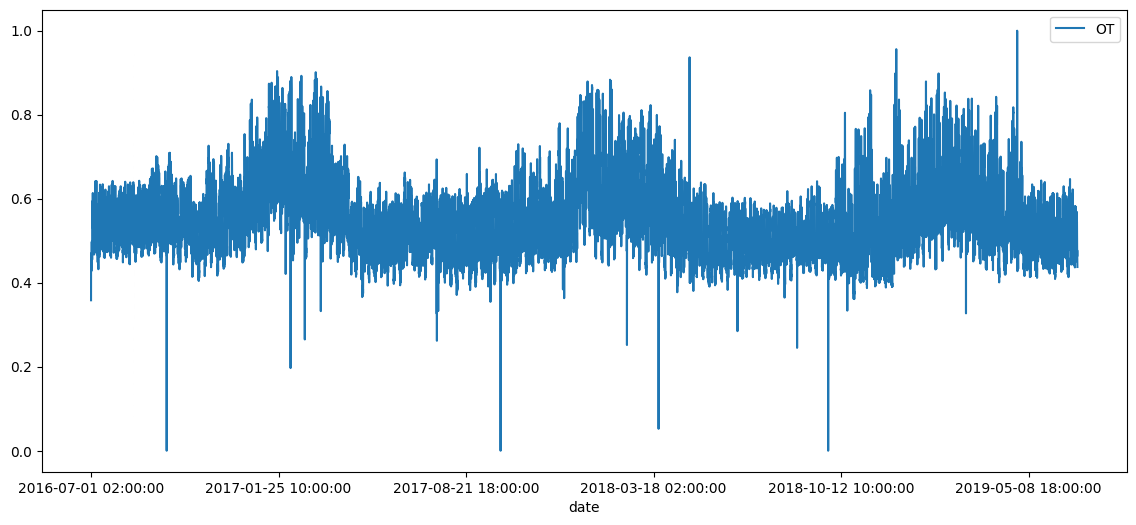

In [44]:
electricity_data.plot()

/Users/dhanunjayelluri/Desktop/Data_Science_2021/Thesis/master-thesis/src/tqts/quantizer/lloyd_max.py:126: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  numerator = integrate.quad(
/Users/dhanunjayelluri/Desktop/Data_Science_2021/Thesis/master-thesis/src/tqts/quantizer/lloyd_max.py:129: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) o

Epoch 1, Boundaries delta: 0.5909383284, Codewords delta: 0.0896532357
Epoch 2, Boundaries delta: 0.0455329747, Codewords delta: 0.0303077439
Epoch 3, Boundaries delta: 0.0257086076, Codewords delta: 0.0203892250
Epoch 4, Boundaries delta: 0.0178740499, Codewords delta: 0.0148690250
Epoch 5, Boundaries delta: 0.0133666672, Codewords delta: 0.0115591716
Epoch 6, Boundaries delta: 0.0104904391, Codewords delta: 0.0096040081
Epoch 7, Boundaries delta: 0.0088029024, Codewords delta: 0.0082699790
Epoch 8, Boundaries delta: 0.0075415878, Codewords delta: 0.0072063920
Epoch 9, Boundaries delta: 0.0066019545, Codewords delta: 0.0063337965
Epoch 10, Boundaries delta: 0.0059222310, Codewords delta: 0.0056039014
Epoch 11, Boundaries delta: 0.0053321311, Codewords delta: 0.0050095549
Epoch 12, Boundaries delta: 0.0048145797, Codewords delta: 0.0045030775
Epoch 13, Boundaries delta: 0.0043578035, Codewords delta: 0.0041279556
Epoch 14, Boundaries delta: 0.0039525982, Codewords delta: 0.0037925294
E

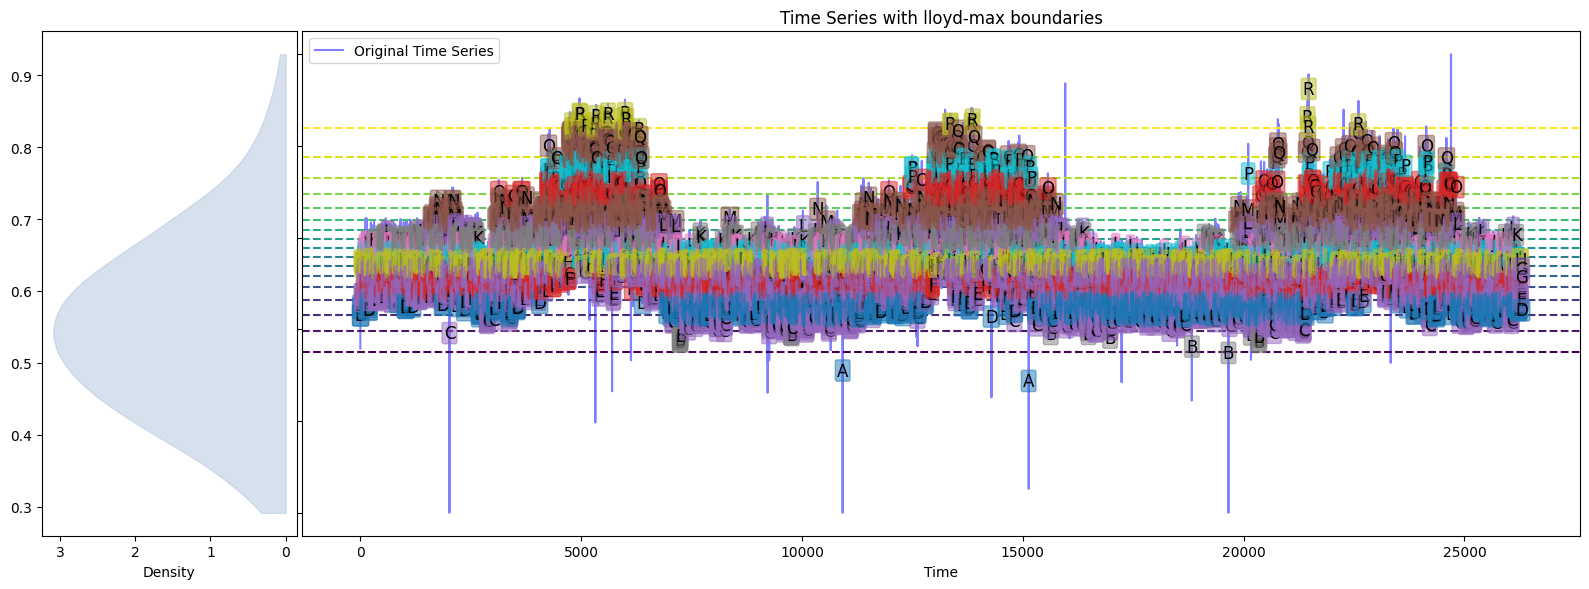

In [45]:
kernel_sax = KernelSAX(kernel='epanechnikov', n_alphabet=18, bandwidth=0.2, epochs=70, paa_window_size=4)
kernel_sax.fit(electricity_data.values, verbose=True)
kernel_sax.plot_with_boundaries(path=IMG_DIR, filename="electricity/Electricity_lloyd.png")
kernel_sax.text_to_df(start_datetime=str(electricity_data.index[0]), csv_path=DATA_DIR+"electricity/electricity_lloyd.csv")

### ETT Hourly dataset

In [21]:
# etth_data = process_time_series(DATA_DIR+"ETT-small/ETTh1.csv", target_col = 'OT', date_col = 'date')
etth_data = load_dataset(DATA_DIR+"ETT-small/ETTh1.csv")
etth_data = etth_data.diff().dropna()
etth_data.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 01:00:00,-0.134,0.067,-0.107,-0.036,-0.061,0.031,-2.743999
2016-07-01 02:00:00,-0.536,-0.335,-0.213,-0.071,-0.365,-0.153,0.000000
2016-07-01 03:00:00,-0.067,0.201,0.000,0.036,0.030,0.061,-2.743000
2016-07-01 04:00:00,0.268,0.000,0.213,0.071,0.061,0.000,-3.096001
2016-07-01 05:00:00,0.268,0.201,0.036,0.071,0.183,0.092,-0.774000


<Axes: xlabel='date'>

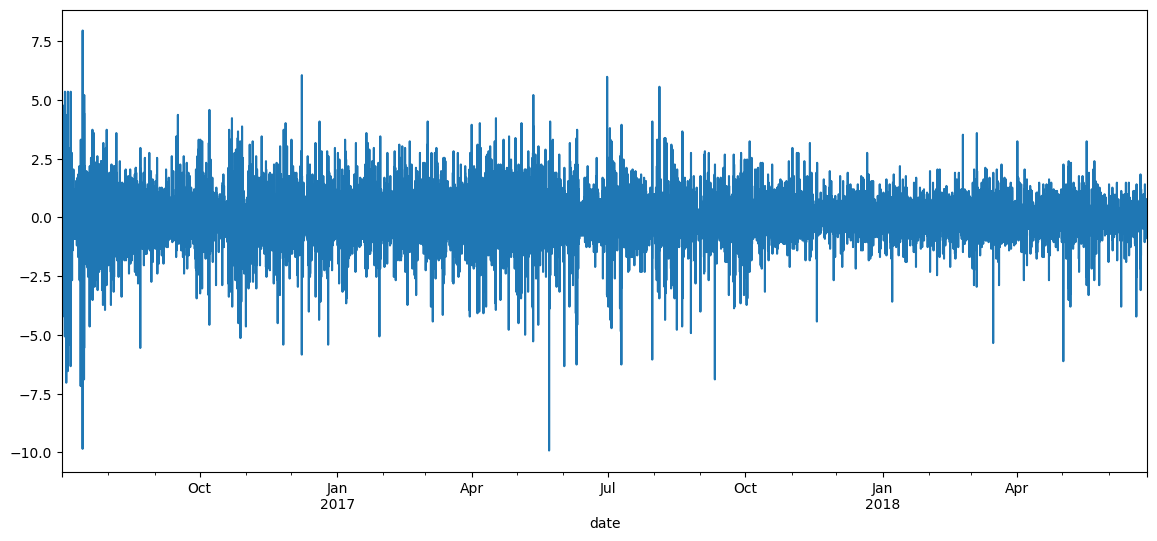

In [22]:
etth_data = etth_data['OT']
etth_data.plot()

Epoch 1, Boundaries delta: 0.9365638789, Codewords delta: 0.7054161895
Epoch 2, Boundaries delta: 0.3412157678, Codewords delta: 0.1834262393
Epoch 3, Boundaries delta: 0.1686401735, Codewords delta: 0.1162638096
Epoch 4, Boundaries delta: 0.1096361495, Codewords delta: 0.0847669889
Epoch 5, Boundaries delta: 0.0793517039, Codewords delta: 0.0650551338
Epoch 6, Boundaries delta: 0.0596572911, Codewords delta: 0.0521452043
Epoch 7, Boundaries delta: 0.0480364469, Codewords delta: 0.0443678044
Epoch 8, Boundaries delta: 0.0403039044, Codewords delta: 0.0385626507
Epoch 9, Boundaries delta: 0.0344363938, Codewords delta: 0.0339562418
Epoch 10, Boundaries delta: 0.0303228680, Codewords delta: 0.0301370310
Epoch 11, Boundaries delta: 0.0270829836, Codewords delta: 0.0269110944
Epoch 12, Boundaries delta: 0.0245696144, Codewords delta: 0.0244115042
Epoch 13, Boundaries delta: 0.0224068872, Codewords delta: 0.0223791851
Epoch 14, Boundaries delta: 0.0205442021, Codewords delta: 0.0205473697
E

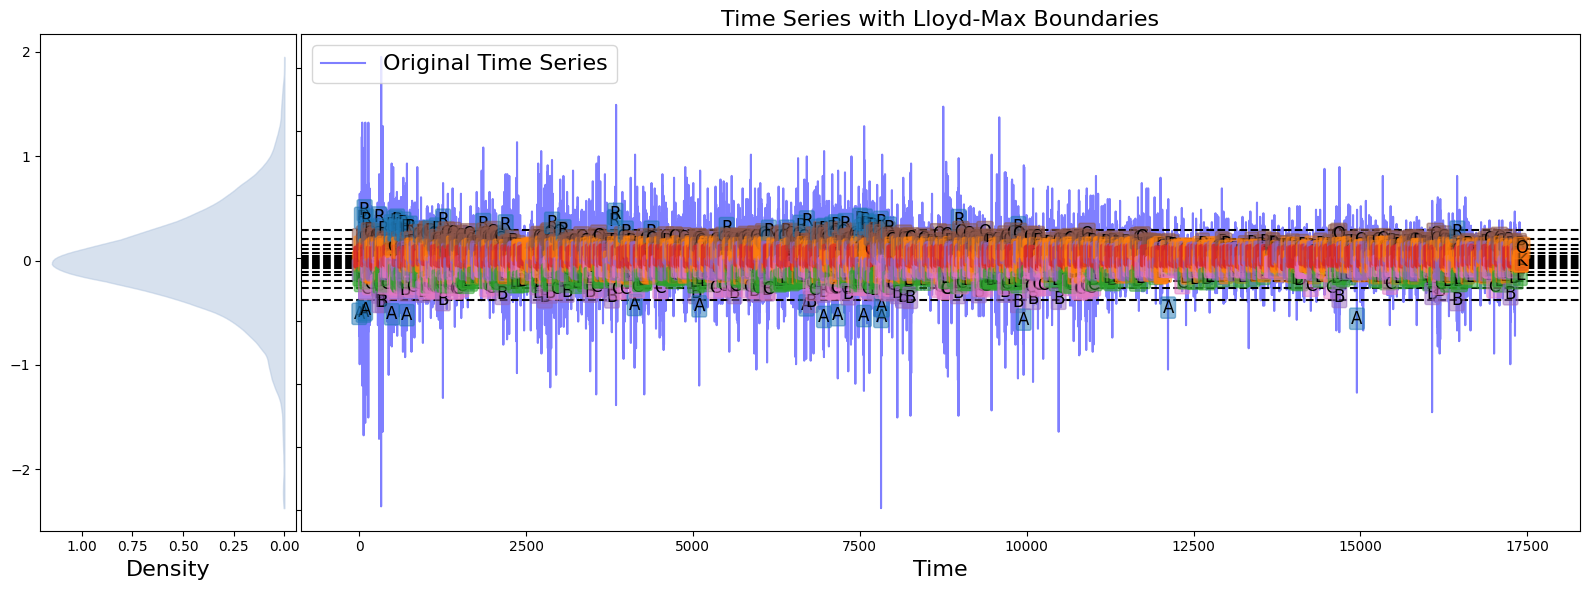

In [23]:
kernel_sax = KernelSAX(kernel='epanechnikov', n_alphabet=18, bandwidth=0.2, epochs=70, paa_window_size=4)
kernel_sax.fit(etth_data.values, verbose=True)
kernel_sax.plot_with_boundaries(path=IMG_DIR, filename="ETT-Small/ETTh1_lloyd_stationary.png")
kernel_sax.text_to_df(start_datetime=str(etth_data.index[0]), csv_path=DATA_DIR+"ETT-Small/ETTh1_lloyd_stationary.csv")

In [ ]:
stationary_data = make_stationary(data)
stationary_data.plot()

In [ ]:
decompose = sm.tsa.seasonal_decompose(data, model='additive', period=52)
trend = decompose.trend
seasonal = decompose.seasonal
trend = trend.fillna(method='ffill')
trend = trend.fillna(method='bfill')
seasonal = seasonal.fillna(method='ffill')
seasonal = seasonal.fillna(method='bfill')

In [ ]:
plt.plot(trend)

In [ ]:
plt.plot(seasonal)

### Kernel SAX on Original Series

In [ ]:
kernel_sax = KernelSAX(kernel='epanechnikov', n_alphabet=18, bandwidth=0.1, epochs=50, paa_window_size=4)
kernel_sax.fit(data.values, verbose=True)
kernel_sax.plot_with_boundaries(path=IMG_DIR, filename="ETTh1_lloyd.png")
kernel_sax.save_alphabets(DATA_DIR+"ETTh1_lloyd.txt")
kernel_sax.text_to_df(start_datetime=str(data.index[0]), csv_path=DATA_DIR+"ETTh1_lloyd.csv")

In [ ]:
s = './data/ETTh1_lloyd.txt'
# Split the string on the period before 'csv'
base, extension = s.rsplit('.', 1)
new_path = f'{base}_boundaries.{extension}'

print(new_path)  # './data/ETTh1_lloyd_boundaries.csv'

### Kernel SAX for trend

In [ ]:
kernel_sax = KernelSAX(kernel='epanechnikov', n_alphabet=18, bandwidth=0.1, epochs=50, paa_window_size=4)
kernel_sax.fit(trend, verbose=True)
kernel_sax.plot_with_boundaries(path=IMG_DIR, filename="ETTh1_lloyd_trend.png")
kernel_sax.save_alphabets(DATA_DIR+"ETTh1_lloyd_trend.txt")
kernel_sax.text_to_df(start_datetime=str(trend.index[0]), csv_path=DATA_DIR+"ETTh1_lloyd_trend.csv")

### Kernel SAX for seasonal

In [ ]:
kernel_sax = KernelSAX(kernel='epanechnikov', n_alphabet=18, bandwidth=0.1, epochs=50, paa_window_size=4)
kernel_sax.fit(seasonal, verbose=True)
kernel_sax.plot_with_boundaries(path=IMG_DIR, filename="ETTh1_lloyd_seasonal.png")
kernel_sax.save_alphabets(DATA_DIR+"ETTh1_lloyd_seasonal.txt")
kernel_sax.text_to_df(start_datetime=str(seasonal.index[0]), csv_path=DATA_DIR+"ETTh1_lloyd_seasonal.csv")

### Kernel SAX for Stationary Data

In [ ]:
kernel_sax = KernelSAX(kernel='epanechnikov', n_alphabet=18, bandwidth=0.1, epochs=50, paa_window_size=4)
kernel_sax.fit(stationary_data, verbose=True)
kernel_sax.plot_with_boundaries(path=IMG_DIR, filename="ETTh1_lloyd_stationary.png")
kernel_sax.save_alphabets(DATA_DIR+"ETTh1_lloyd_stationary.txt")
kernel_sax.text_to_df(start_datetime=str(seasonal.index[0]), csv_path=DATA_DIR+"ETTh1_lloyd_stationary.csv")

In [ ]:
kernel_sax

In [ ]:
new_data = pd.read_csv(DATA_DIR+"ETTh1_lloyd.csv", index_col='timestamp')

In [ ]:
new_data['encoded_alphabets'][:500].plot()

In [ ]:
def load_text_data(file_path: str) -> str:
    """
    Load character level text data from a file.
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        text_data = file.read()
    return text_data

In [ ]:
def split_text_data(text_data: str, train_ratio: float=0.8) -> tuple:
    """
    Split text data into train and test datasets sequentially.
    
    :param text_data: The complete character-level text data.
    :param train_ratio: Ratio of data to be used for training (default is 0.8).
    :return: train_data, test_data
    """
    # Calculate the split index
    split_index = int(len(text_data) * train_ratio)
    
    # Split the data
    train_data = text_data[:split_index]
    test_data = text_data[split_index:]
    
    return train_data, test_data

In [ ]:
ETTh1_text_data = load_text_data(DATA_DIR + 'ETTh1_lloyd.txt')

In [ ]:
ETTh1_text_data[:100]

In [ ]:
ETTh1_train, ETTh1_test = split_text_data(ETTh1_text_data)
print(f"Train text len: {len(ETTh1_train)}, test text len: {len(ETTh1_test)}")

In [ ]:
def calculate_vocab_size(text_data):
    """
    Calculate the vocabulary size from the text data.
    """
    return len(set(text_data))

def suggest_sequence_length(text_data, num_samples=1000):
    """
    Suggest a sequence length based on the average length of sentences/phrases in the text data.
    """
    # Split the text into sentences or phrases
    sentences = text_data.split('\n')  # Assuming each line is a sentence/phrase
    sample_sentences = sentences[:num_samples]  # Sample a subset for analysis

    # Calculate average length
    avg_length = sum(len(sentence) for sentence in sample_sentences) / len(sample_sentences)
    return int(avg_length)

# Usage with the training data
vocab_size = calculate_vocab_size(ETTh1_train)
suggested_seq_len = suggest_sequence_length(ETTh1_train)

print(vocab_size, suggested_seq_len)


In [ ]:
def save_data_to_file(data: list, file_path: str) -> None:
    """
    Save the given data to a text file.

    Args:
        data (str): The text data to be saved.
        file_path (str): Path of the file where the data will be saved.
    """
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(data)
    print(f"Saved data to {file_path}")

# Usage
train_file_path = DATA_DIR +  'ETTh1_train.txt'  
test_file_path = DATA_DIR + 'ETTh1_test.txt'   

# Saving the data
save_data_to_file(ETTh1_train, train_file_path)
save_data_to_file(ETTh1_test, test_file_path)

In [ ]:
char_to_idx = {char: idx for idx, char in enumerate(sorted(set(ETTh1_text_data)))}

# Convert all characters in the data to their corresponding index
indexed_data = [char_to_idx[char] for char in ETTh1_text_data]

# Creating a DataFrame for plotting
df = pd.DataFrame(indexed_data, columns=['Character Index'])

# Plotting the data
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['Character Index'], label='Character Index')
plt.title('Character Index Time Series')
plt.xlabel('Time Step')
plt.ylabel('Character Index')
plt.legend()
plt.show()

### True vs Pred characters

In [ ]:
import pandas as pd
import numpy as np

# Function to vectorize the character assignment
def vectorized_find_character(values, lower_boundaries, upper_boundaries, alphabets):
    # Initialize an array to store the characters
    characters = np.full(values.shape, None)

    # Iterate over each boundary and assign characters
    for i, (lower, upper) in enumerate(zip(lower_boundaries, upper_boundaries)):
        mask = (values >= lower) & (values < upper)
        characters[mask] = alphabets[i]
    
    return characters

# Step 1: Load the boundaries and characters
boundaries_df = pd.read_csv('./data/ETTh1_lloyd_stationary_boundaries.csv')

# Step 2: Load true and predicted values
true_values = np.load('./gpu_results/ETTh1_lloyd_stationary_48_Autoformer_ETTh1_ftM_sl96_ll48_pl48_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0/true.npy')
pred_values = np.load('./gpu_results/ETTh1_lloyd_stationary_48_Autoformer_ETTh1_ftM_sl96_ll48_pl48_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0/pred.npy')


In [ ]:
# Flattening the true_values and pred_values arrays
true_values_flat = true_values.flatten()
pred_values_flat = pred_values.flatten()

# Converting boundaries and alphabets to numpy arrays for vectorized operations
lower_boundaries = boundaries_df['lower_boundaries'].to_numpy()
upper_boundaries = boundaries_df['upper_boundaries'].to_numpy()
alphabets = boundaries_df['alphabets'].to_numpy()

In [ ]:
# Applying the function to true and predicted values
true_characters_vec = vectorized_find_character(true_values_flat, lower_boundaries, upper_boundaries, alphabets)
pred_characters_vec = vectorized_find_character(pred_values_flat, lower_boundaries, upper_boundaries, alphabets)

In [ ]:
# Create a new DataFrame with true values, predicted values, and their corresponding characters
data_df = pd.DataFrame({
    'True Values': true_values_flat,
    'Predicted Values': pred_values_flat,
    'True Characters': true_characters_vec,
    'Predicted Characters': pred_characters_vec
})
# Calculating character distances
mask = (data_df['True Characters'].notna()) & (data_df['Predicted Characters'].notna())
data_df['Character Distance'] = np.abs(data_df.loc[mask, 'True Characters'].apply(ord) - data_df.loc[mask, 'Predicted Characters'].apply(ord))

# Computing the overall average character distance
average_distance_vec = np.mean(data_df['Character Distance'])

print("Average Character Distance:", average_distance_vec)